In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

data_dir = 'C:/Users/avp/OneDrive - HKUST Connect/Desktop/DATA/data [N=10000, p1=3, p=150, L=150, alpha=0.1, SNR=1, K=100]'

# A. Generate Data

In [2]:
#!Rscript generate_data.R --N_data=10000

# B. Train Model

In [3]:
class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.beta_dir = os.path.join(data_dir, 'beta')
        self.v_thresh_dir = os.path.join(data_dir, 'v_thresh')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.beta_files = [f for f in os.listdir(self.beta_dir) if f.startswith('beta_') and f.endswith('.txt')]
        self.v_thresh_files = [f for f in os.listdir(self.v_thresh_dir) if f.startswith('v_thresh_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)

        beta_file = os.path.join(self.beta_dir, self.beta_files[idx])
        beta = np.loadtxt(beta_file)
        
        v_thresh_file = os.path.join(self.v_thresh_dir, self.v_thresh_files[idx])
        v_thresh = np.loadtxt(v_thresh_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(beta, dtype=torch.float32), torch.tensor(v_thresh, dtype=torch.float32)

In [4]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_indices, test_indices

In [5]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
        nn.ReLU
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = (torch.sigmoid(self.fc3(x)) + 1)*0.5 # Busquem el rang (0.5, 1)
        return x

In [43]:
def sigma_v(x, v, exponent=10):
    v = v.view(-1, 1)
    return 1 / (1 + torch.exp(-exponent*(x + v)))

def FDR_surr(v, Phi, beta):
    return torch.sum(sigma_v((1 - beta) * Phi, v), dim=1) / torch.sum(sigma_v(Phi, v), dim=1)

In [110]:
class CustomLoss(nn.Module):
    def __init__(self, alpha, lambda1=1, lambda2=1, lambda3=0.0):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        self.mse = nn.MSELoss()

    def forward(self, v_pred, v_true, Phi, beta):
        mse_loss = self.mse(v_pred, v_true)
        
        FDR_hat = FDR_surr(v_pred, Phi, beta)
        larger_fdr_loss = torch.mean(torch.clamp(FDR_hat - self.alpha, min=0)**2)
        smaller_fdr_loss = torch.mean(torch.clamp(self.alpha - FDR_hat, min=0)**2)
        
        loss = self.lambda1 * mse_loss + self.lambda2 * larger_fdr_loss + self.lambda3 * smaller_fdr_loss
        
        return loss

In [111]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True):
    model.eval()
    losses_over_train = []
    with torch.no_grad():
        for Phis, betas, v_opt in train_loader:
            outputs = model(Phis)
            loss = criterion(outputs.squeeze(), v_opt, Phis, betas)
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {sum(losses_over_train) / len(train_loader):.4f}')
    
    losses_over_test = []
    with torch.no_grad():
        for Phis, betas, v_opt in test_loader:
            outputs = model(Phis)
            loss = criterion(outputs.squeeze(), v_opt, Phis, betas)
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {sum(losses_over_test) / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
        for _, (Phis, betas, v_opt) in progress_bar:
            optimizer.zero_grad()
            outputs = model(Phis)
            loss = criterion(outputs.squeeze(), v_opt, Phis, betas)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)
        train_losses.append(sum(losses_over_train) / len(train_loader))
        test_losses.append(sum(losses_over_test) / len(test_loader))
    return train_losses, test_losses

In [112]:
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt')))

hparams = {"batch_size": 16,
           "learning_rate": 0.001,
           "num_epochs": 10}

train_loader, test_loader, train_indices, test_indices = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size)
criterion = CustomLoss(0.1)
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_losses, test_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"])

Epoch 1/10: 100%|██████████| 500/500 [00:03<00:00, 144.17it/s]


Epoch [1/10], Running Loss: 0.8417
Train Loss: 0.8369
Test Loss: 0.8376


Epoch 2/10: 100%|██████████| 500/500 [00:03<00:00, 143.80it/s]


Epoch [2/10], Running Loss: 0.8352
Train Loss: 0.8325
Test Loss: 0.8339


Epoch 3/10: 100%|██████████| 500/500 [00:44<00:00, 11.31it/s]


Epoch [3/10], Running Loss: 0.8324
Train Loss: 0.8306
Test Loss: 0.8320


Epoch 4/10: 100%|██████████| 500/500 [00:03<00:00, 147.19it/s]


Epoch [4/10], Running Loss: 0.8305
Train Loss: 0.8291
Test Loss: 0.8306


Epoch 5/10: 100%|██████████| 500/500 [00:03<00:00, 147.44it/s]


Epoch [5/10], Running Loss: 0.8293
Train Loss: 0.8281
Test Loss: 0.8294


Epoch 6/10: 100%|██████████| 500/500 [00:03<00:00, 148.98it/s]


Epoch [6/10], Running Loss: 0.8284
Train Loss: 0.8273
Test Loss: 0.8293


Epoch 7/10: 100%|██████████| 500/500 [00:03<00:00, 147.49it/s]


Epoch [7/10], Running Loss: 0.8277
Train Loss: 0.8265
Test Loss: 0.8293


Epoch 8/10: 100%|██████████| 500/500 [00:03<00:00, 148.35it/s]


Epoch [8/10], Running Loss: 0.8269
Train Loss: 0.8255
Test Loss: 0.8293


Epoch 9/10: 100%|██████████| 500/500 [00:03<00:00, 147.94it/s]


Epoch [9/10], Running Loss: 0.8261
Train Loss: 0.8247
Test Loss: 0.8296


Epoch 10/10: 100%|██████████| 500/500 [00:03<00:00, 147.10it/s]


Epoch [10/10], Running Loss: 0.8252
Train Loss: 0.8239
Test Loss: 0.8297


# Evaluate Model

In [113]:
losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)

Train Loss: 0.8239
Test Loss: 0.8297


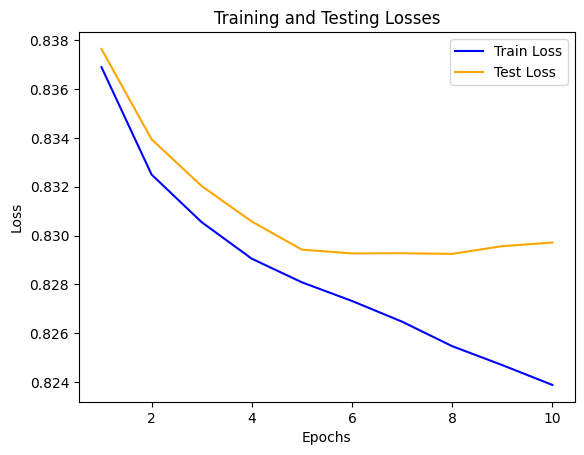

In [114]:
epochs = range(1, len(train_losses) + 1)

# Plot both training and testing losses
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='orange')

# Adding titles and labels
plt.title('Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
# Show the plot
plt.show()

## v distribution

### Training Data

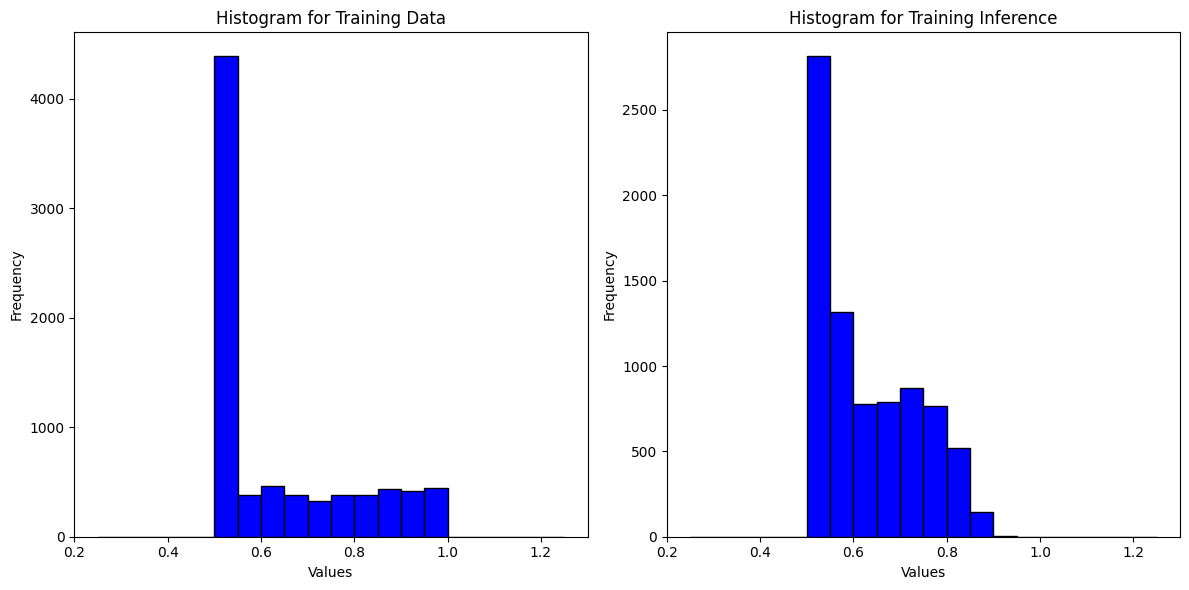

In [115]:
model.eval()

with torch.no_grad():
    train_loader_v = []
    train_infer_v = []
    for Phis, betas, v_opt in train_loader:
        train_loader_v += v_opt.numpy().squeeze().tolist()
        train_infer_v += model(Phis).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

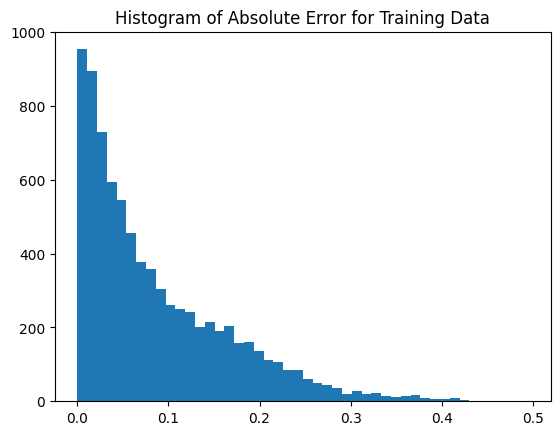

In [116]:
plt.hist(np.abs(np.array(train_loader_v) - np.array(train_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Training Data")
plt.show()

### Test Data

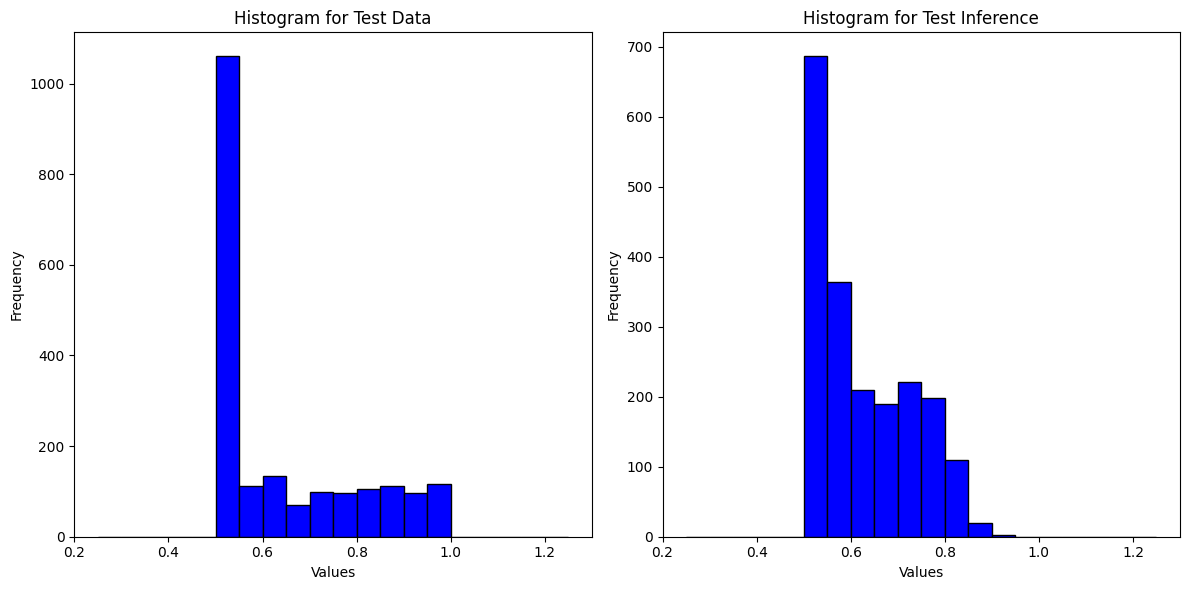

In [117]:
model.eval()

with torch.no_grad():
    test_loader_v = []
    test_infer_v = []
    for Phis, betas, v_opt in test_loader:
        test_loader_v += v_opt.numpy().squeeze().tolist()
        test_infer_v += model(Phis).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

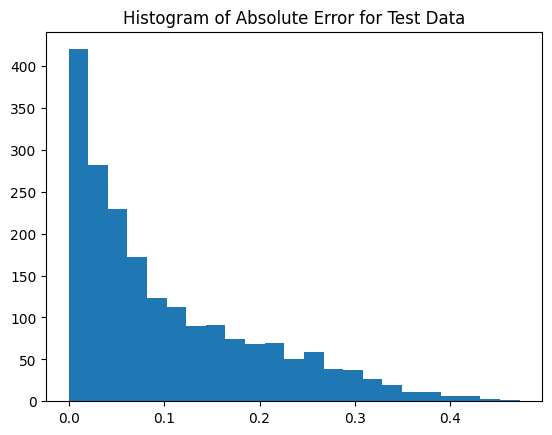

In [118]:
plt.hist(np.abs(np.array(test_loader_v) - np.array(test_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Test Data")
plt.show()

## FDR and TPR

In [119]:
phi_dir = os.path.join(data_dir, 'Phi_mat')
true_actives_dir = os.path.join(data_dir, 'true_actives')

phi_data = [np.loadtxt(os.path.join(phi_dir, f)) 
            for f in os.listdir(phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
true_actives_data = [np.loadtxt(os.path.join(true_actives_dir, f), dtype=int) - 1  # We substract 1 as they are R indices (starting from 1)
                     for f in os.listdir(true_actives_dir) if f.startswith('true_actives_') and f.endswith('.txt')]

FDRs = []  # or FDPs
TPRs = []  # or TPPs
for phi, true_actives in zip(phi_data, true_actives_data):
    with torch.no_grad():   
        v = model(torch.Tensor(phi)).numpy()[0]
    selected = np.where(phi > v)[0]
    selected_actives = np.intersect1d(selected, true_actives, assume_unique=True)
    selected_null = np.setdiff1d(selected, selected_actives, assume_unique=True)
    FDRs.append(len(selected_null)/max(len(selected), 1))
    TPRs.append(len(selected_actives)/max(len(true_actives), 1))

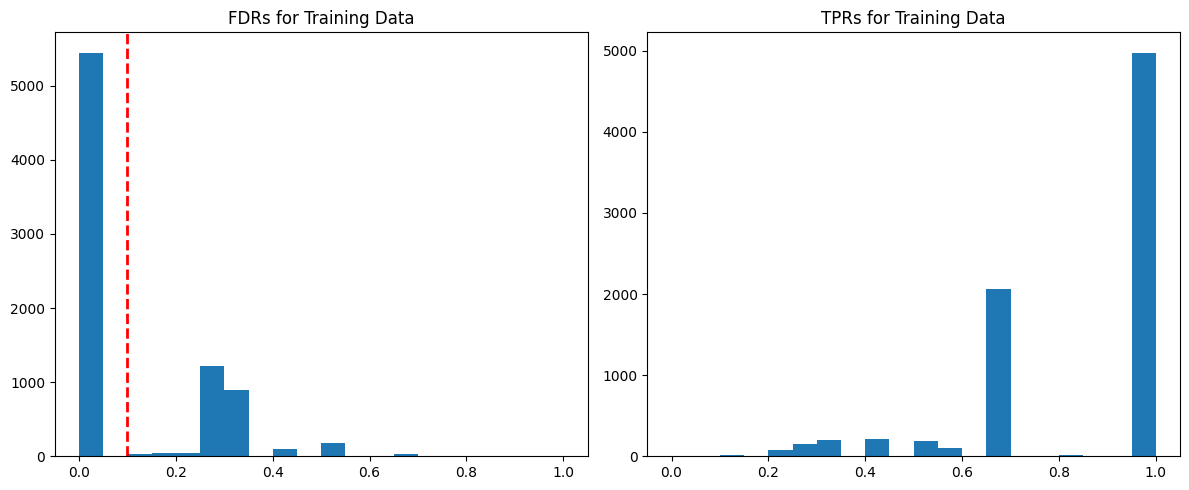

In [120]:
bins = np.arange(0, 1.05, 0.05)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(np.array(FDRs)[train_indices], bins=bins)
axs[0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0].set_title("FDRs for Training Data")

axs[1].hist(np.array(TPRs)[train_indices], bins=bins)
axs[1].set_title("TPRs for Training Data")

plt.tight_layout()
plt.show()

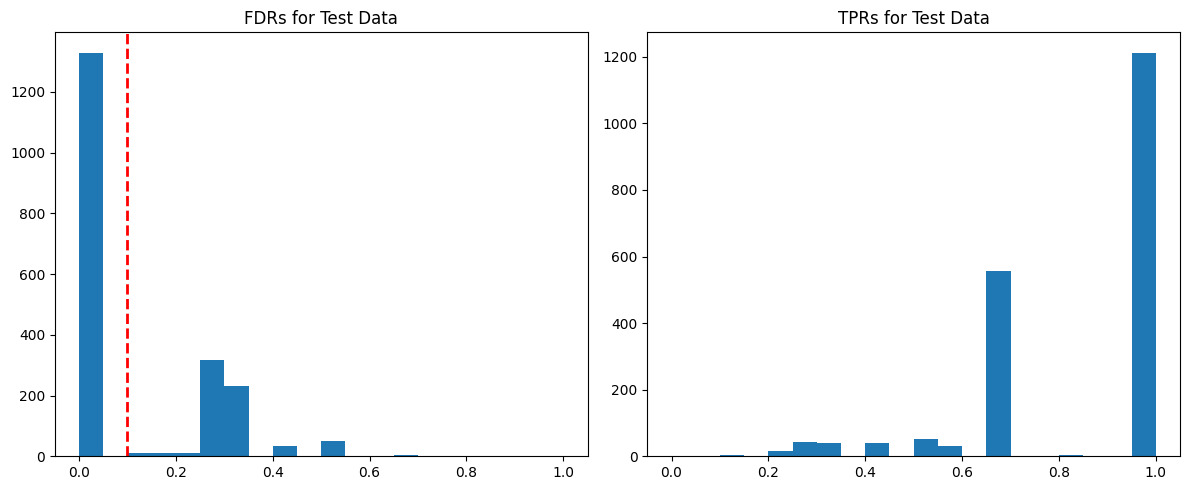

In [121]:
bins = np.arange(0, 1.05, 0.05)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(np.array(FDRs)[test_indices], bins=bins)
axs[0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0].set_title("FDRs for Test Data")

axs[1].hist(np.array(TPRs)[test_indices], bins=bins)
axs[1].set_title("TPRs for Test Data")

plt.tight_layout()
plt.show()